## В данном мини-проекте проведем А/А-тестирование мобильного приложения
Посчитаем результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

## Задачи
1. Запустить A/A-тест.
2. Посчитать FPR на уровне альфа = 0.05 (ставим подвыборки без возвращения объемом 1000). 
3. Найти причины поломки сплит-системы, ориентируясь на результаты эксперимента.
4. Написать выводы, которые можно сделать на основе анализа результатов A/A-теста.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\yarus\projects\data\hw_aa.csv", sep=';')

In [3]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


## Описание колонок:
* experimentVariant – вариант эксперимента
* version – версия приложения
* purchase – факт покупки

Удалим ненужный столбец.

In [4]:
df = df.drop(columns=df.columns[0])

In [5]:
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [6]:
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

In [7]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

Разделим данные на две группы.

In [8]:
df_group_0 = df.query('experimentVariant == 0')
df_group_1 = df.query('experimentVariant == 1')

In [9]:
df_group_0.head()

,uid,experimentVariant,version,purchase
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
6,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
8,45c48cce2e2d7fbdea1afc51c7c6ad26,0,v2.8.0,0
11,c20ad4d76fe97759aa27a0c99bff6710,0,v2.8.0,0
16,70efdf2ec9b086079795c442636b55fb,0,v2.8.0,0


In [10]:
df_group_1.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
5,1679091c5a880faf6fb5e6087eb1b2dc,1,v2.8.0,0


## Запустим А/А-тест

  0%|          | 0/1000 [00:00<?, ?it/s]

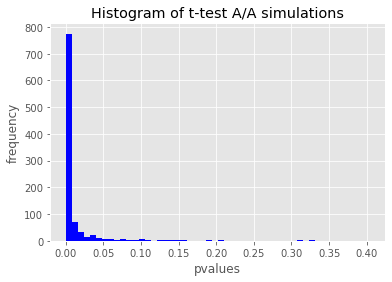

FPR = 0.927


In [11]:
simulations = 1000
n = 1000

result = []

for i in tqdm(range(simulations)):
    samples_0 = df_group_0['purchase'].sample(n, replace = False).values
    samples_1 = df_group_1['purchase'].sample(n, replace = False).values
    result.append(stats.ttest_ind(samples_0, samples_1, equal_var = False)[1])

plt.hist(result, bins = 50, color='blue')
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =', sum(np.array(result) < 0.05) / simulations)

### Результат A/A-теста
Показатель FPR > 0.05, т.е. доля ложноположительных оценок (доля симуляций, в которых значение p-value < 0.05) составляет больше 5%, причем значительно больше - 94,5 %. Т.е. в подавляющем большинстве случаев мы получаем статистически значимые различия между двумя группами, которых на самом деле быть не должно. Значит, что-то пошло не так, и необходимо искать причину поломки.

## Начинаем искать поломку
Сгруппируем наш датасет по номеру группы.

In [12]:
df_grouped = df.groupby('experimentVariant').agg({'uid': 'count', 'purchase': 'sum'})

In [13]:
df_grouped

,uid,purchase
experimentVariant,,
0,63102,1511
1,63916,3403


Посчитаем конверсию.

In [14]:
df_grouped['conversion'] = df_grouped['purchase'] / df_grouped['uid']

In [15]:
df_grouped

,uid,purchase,conversion
experimentVariant,,,
0,63102,1511,0.023945
1,63916,3403,0.053242


Количество пользователей в двух группах примерно одинаковое, однако конверсия в нулевой группе заметно ниже, чем в первой. Пока ничего удивительного, так как это согласуется с результатом А/А-теста.

Теперь сгруппируем наш датасет по номеру группы и версии мобильного приложения и посчитаем конверсию для каждой подгруппы.

In [16]:
df_grouped_ver = df.groupby(['experimentVariant', 'version']).agg({'uid': 'count', 'purchase': 'sum'})

In [17]:
df_grouped_ver

uid  purchase
experimentVariant version                  
0                 v2.8.0    41283        41
                  v2.9.0    11921       890
                  v3.7.4.0   4204       252
                  v3.8.0.0   5694       328
1                 v2.8.0    41552      1895
                  v2.9.0    12033       858
                  v3.7.4.0   4221       266
                  v3.8.0.0   6110       384

In [18]:
df_grouped_ver['conversion'] = df_grouped_ver['purchase'] / df_grouped_ver['uid']

In [19]:
df_grouped_ver

uid  purchase  conversion
experimentVariant version                              
0                 v2.8.0    41283        41    0.000993
                  v2.9.0    11921       890    0.074658
                  v3.7.4.0   4204       252    0.059943
                  v3.8.0.0   5694       328    0.057604
1                 v2.8.0    41552      1895    0.045606
                  v2.9.0    12033       858    0.071304
                  v3.7.4.0   4221       266    0.063018
                  v3.8.0.0   6110       384    0.062848

Можно заметить, что конверсия для версии v2.8.0 заметно различается в двух вариантах эксперимента (в нулевую группу попадает значительно меньше покупателей, чем в первую). В результате нарушается репрезентативность тестовых групп. Возможно, причина поломки именно в этой версии приложения.

## Попробуем запустить A/A-тест для каждой версии приложения по отдельности

  0%|          | 0/1000 [00:00<?, ?it/s]

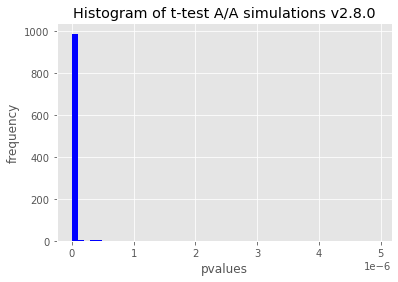

FPR = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

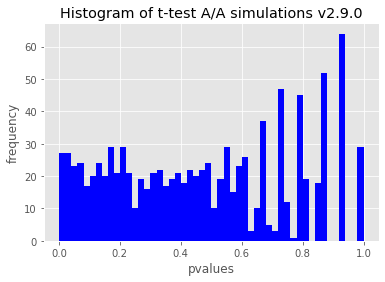

FPR = 0.065


  0%|          | 0/1000 [00:00<?, ?it/s]

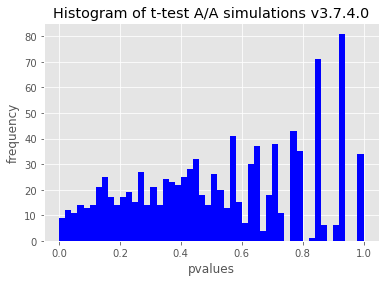

FPR = 0.024


  0%|          | 0/1000 [00:00<?, ?it/s]

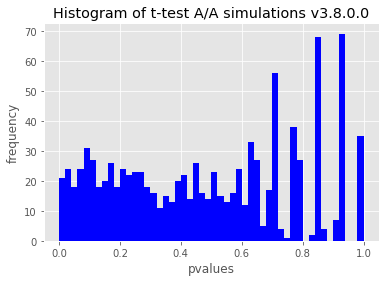

FPR = 0.053


In [20]:
simulations = 1000
n = 1000
versions = df['version'].unique()

for ver in versions:
    
    result = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        samples_0 = df_group_0[df_group_0['version'] == ver]['purchase'].sample(n, replace = False).values
        samples_1 = df_group_1[df_group_1['version'] == ver]['purchase'].sample(n, replace = False).values
        result.append(stats.ttest_ind(samples_0, samples_1, equal_var = False)[1]) # сохраняем p-value

    plt.hist(result, bins = 50, color='blue')
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of t-test A/A simulations {}".format(ver))
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    print('FPR =', sum(np.array(result) < 0.05) / simulations)

Также проведем тесты в разрезе версий, но не на 1000 значений, а на 85 % от минимального количества в сравниваемых группах, также используя подвыборки без возвращения.

  0%|          | 0/1000 [00:00<?, ?it/s]

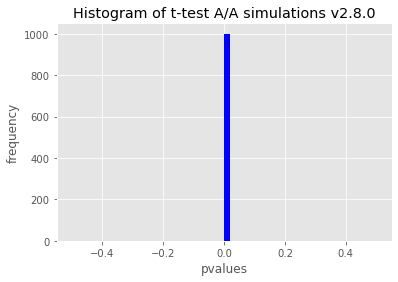

FPR = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

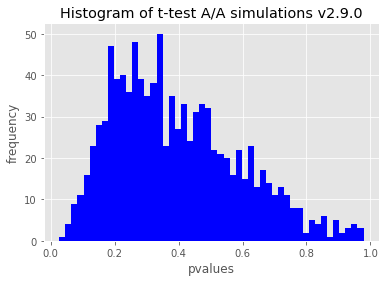

FPR = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

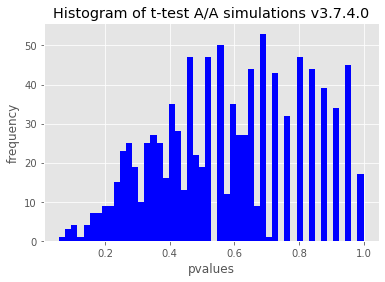

FPR = 0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

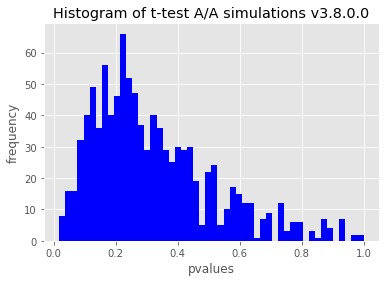

FPR = 0.016


In [21]:
simulations = 1000

versions = df['version'].unique()

for ver in versions:
    
    group_0 = df_group_0[df_group_0['version'] == ver]['purchase']
    group_1 = df_group_1[df_group_1['version'] == ver]['purchase']

    result = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        samples_0 = group_0.sample(round(0.85 * min(len(group_0), len(group_1))), replace = False).values
        samples_1 = group_1.sample(round(0.85 * min(len(group_0), len(group_1))), replace = False).values
        result.append(stats.ttest_ind(samples_0, samples_1, equal_var = False)[1]) # сохраняем p-value

    plt.hist(result, bins = 50, color='blue')
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of t-test A/A simulations {}".format(ver))
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    print('FPR =', sum(np.array(result) < 0.05) / simulations)

### Результаты A/A-теста для каждой версии приложения
Теперь хорошо видно, что для версии v2.8.0 t-тест выдает значимые различия на каждой итерации теста (FPR составляет 1.0), тогда как с остальными версиями все нормально - доля ложноположительных оценок низкая. Значит, причина поломки действительно кроется в версии v2.8.0. Возможно, что для данной версии сломан рандомизатор, распределяющий пользователей по группам эксперимента.

## Теперь запустим A/A-тест, предварительно исключив из выборки проблемную версию

  0%|          | 0/1000 [00:00<?, ?it/s]

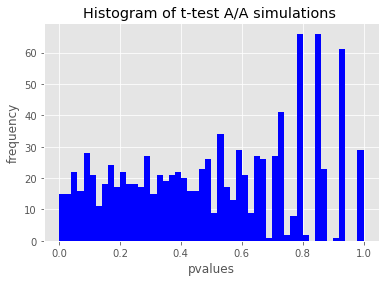

FPR = 0.038


In [22]:
group_0 = df_group_0[df_group_0['version'] != 'v2.8.0']['purchase']
group_1 = df_group_1[df_group_1['version'] != 'v2.8.0']['purchase']

simulations = 1000
n = 1000

result = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    samples_0 = group_0.sample(n, replace = False).values
    samples_1 = group_1.sample(n, replace = False).values
    result.append(stats.ttest_ind(samples_0, samples_1, equal_var = False)[1]) # сохраняем p-value

plt.hist(result, bins = 50, color='blue')
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =', sum(np.array(result) < 0.05) / simulations)

Без проблемной версии все работает нормально, и мы находимся в пределах допустимого значения FPR. Теперь мы знаем, что именно у нас сломалось. 

P.S. Также можно заметить, что в нашем примере при повторных запусках А/А-тестов в некоторых случаях FPR будет немного превышать пороговое значение (0.05). Это связано с относительно небольшим числом наблюдений (1000) в выборках на каждой итерации теста. Если увеличить это значение (например, до 90% от числа наблюдений в исходных группах), то оценка FPR будет более точной.

  0%|          | 0/1000 [00:00<?, ?it/s]

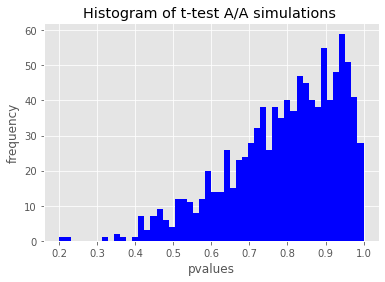

FPR = 0.0


In [23]:
group_0 = df_group_0[df_group_0['version'] != 'v2.8.0']['purchase']
group_1 = df_group_1[df_group_1['version'] != 'v2.8.0']['purchase']

simulations = 1000

result = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    samples_0 = group_0.sample(round(0.9 * min(len(group_0), len(group_1))), replace = False).values
    samples_1 = group_1.sample(round(0.9 * min(len(group_0), len(group_1))), replace = False).values
    result.append(stats.ttest_ind(samples_0, samples_1, equal_var = False)[1]) # сохраняем p-value

plt.hist(result, bins = 50, color='blue')
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =', sum(np.array(result) < 0.05) / simulations)